In [1]:
from dataset import load_dataset
from utils import rotation_matrix_z
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import plotly.graph_objects as go

In [2]:
dataset_path = "data/sphere_simple/"

ds = load_dataset(dataset_path, "valid")

In [ ]:
iterator = tf.data.make_one_shot_iterator(ds)
inputs = iterator.get_next()

with tf.Session() as sess:
    world_pos = sess.run(inputs["world_pos"])
    faces = sess.run(inputs["cells"])


In [4]:
def rotate_world_pos(world_pos, angle:float):
    with tf.Session() as sess:
        rotation_matrix = sess.run(rotation_matrix_z(angle))
    world_pos_rot = np.einsum("tnc,cj->tnj", world_pos, rotation_matrix)
    return world_pos_rot

def translate_world_pos(world_pos, translation_vector):
    translation_vector = np.expand_dims(translation_vector, axis=0)
    translation_vector = np.expand_dims(translation_vector, axis=0)
    translation_vector = np.repeat(translation_vector, world_pos.shape[0], axis=0)
    translation_vector = np.repeat(translation_vector, world_pos.shape[1], axis=1)
    return world_pos+translation_vector

## Verify Translation

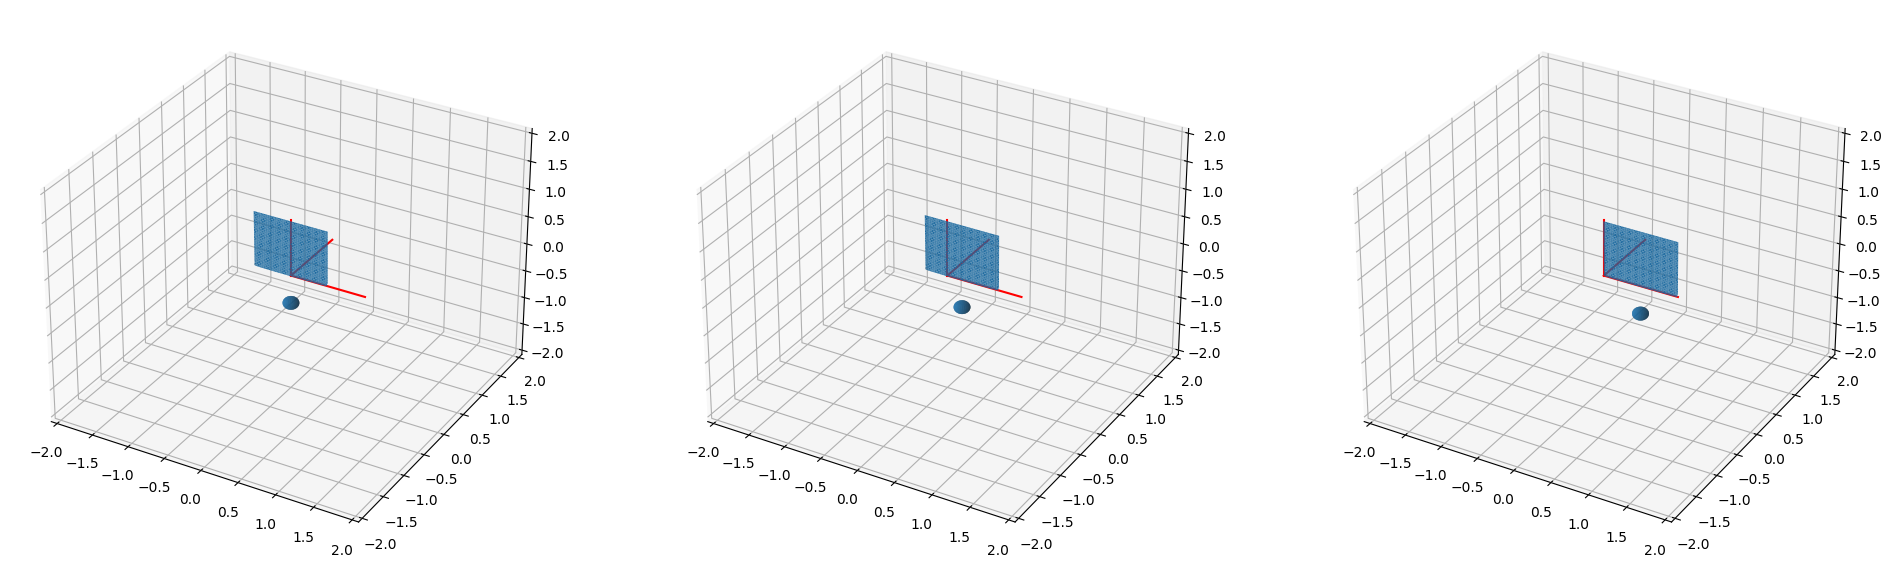

In [5]:
translate_amount = [0, 0.2, 0.5]
step = 5

fig = plt.figure(figsize=(8 * len(translate_amount), 16))
axes = [fig.add_subplot(1, len(translate_amount), i+1, projection="3d") for i in range(len(translate_amount))]

for i, trans_amount in enumerate(translate_amount):
    world_pos_trans = translate_world_pos(world_pos, np.array([trans_amount, 0, 0]))

    axes[i].plot(np.zeros(2), np.zeros(2), np.array([0, 1]), c="r")
    axes[i].plot(np.zeros(2), np.array([0, 1]), np.zeros(2), c="r")
    axes[i].plot(np.array([0, 1]), np.zeros(2), np.zeros(2), c="r")

    bound = [[-2, -2, -2], [2, 2, 2]]
    axes[i].set_xlim([bound[0][0], bound[1][0]])
    axes[i].set_ylim([bound[0][1], bound[1][1]])
    axes[i].set_zlim([bound[0][2], bound[1][2]])

    pos = world_pos_trans[step]
    f = faces[step]
    axes[i].plot_trisurf(pos[:, 0], pos[:, 1], f, pos[:, 2], shade=True)


plt.show()


## Verify Rotation

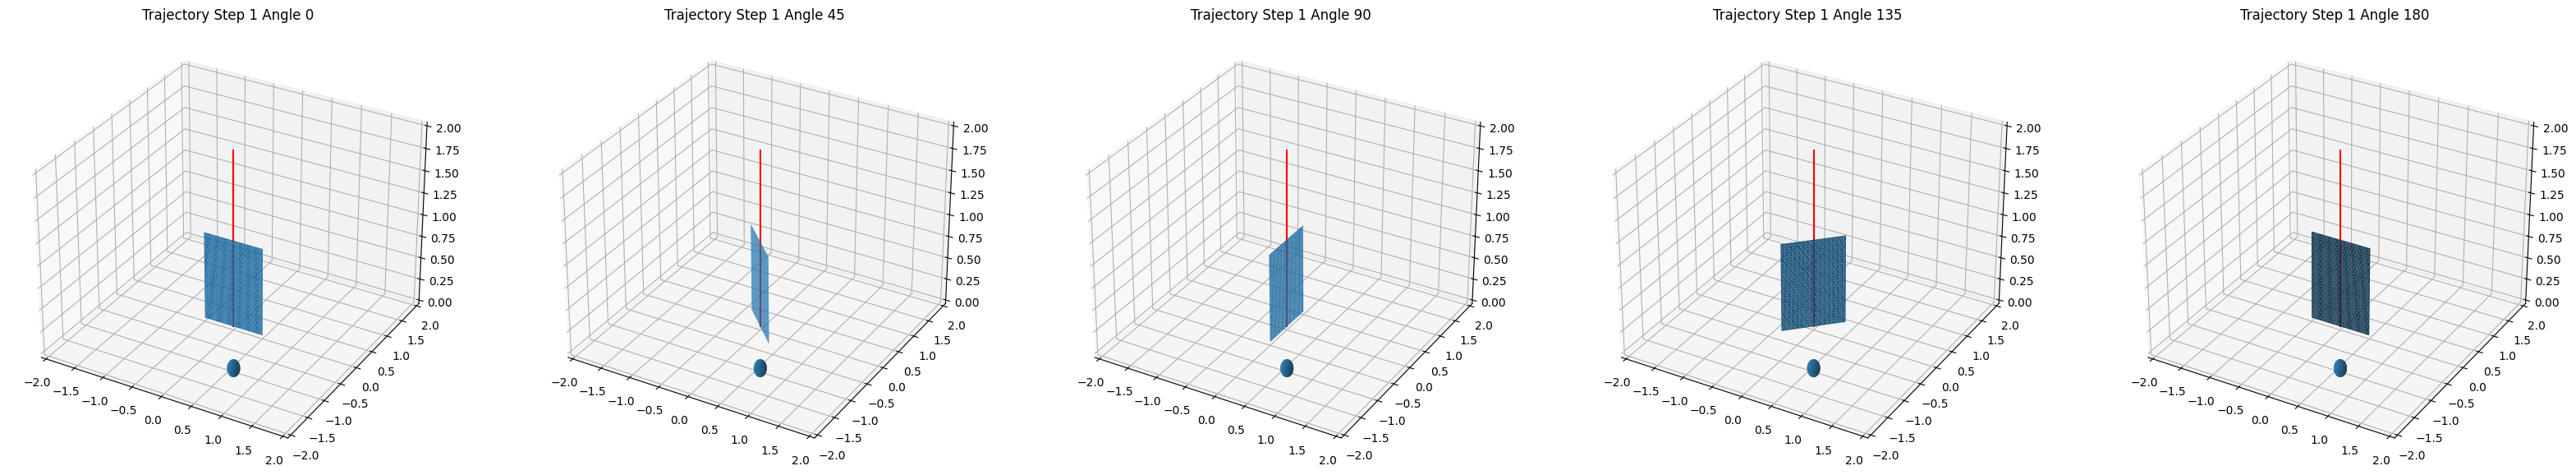

In [6]:

angles = [0, 45, 90, 135, 180]
step = 1

fig = plt.figure(figsize=(8*len(angles), 16))
axes = [fig.add_subplot(1, len(angles), i+1, projection="3d") for i in range(len(angles))]
world_pos_rots = [rotate_world_pos(world_pos, angle) for angle in angles]

for i in range(len(angles)):
    bb_min = world_pos_rots[i][step].min(axis=0)
    bb_max = world_pos_rots[i][step].max(axis=0)
    bound = (bb_min, bb_max)
    bound = [
        [-2, -2, 0],
        [2, 2, 2]
    ]
    axes[i].set_xlim([bound[0][0], bound[1][0]])
    axes[i].set_ylim([bound[0][1], bound[1][1]])
    axes[i].set_zlim([bound[0][2], bound[1][2]])

    axes[i].plot(np.zeros(2), np.zeros(2), np.array([0, 2]), c="r")
    pos = world_pos_rots[i][step]  # pred_pos
    f = faces[step]
    axes[i].plot_trisurf(pos[:, 0], pos[:, 1], f, pos[:, 2], shade=True)
    axes[i].set_title("Trajectory Step %d Angle %d" % (step, angles[i]))
plt.show()

In [7]:
angles = [0, 45, 90, 135, 180]
step = 1

world_pos_rots = np.array([rotate_world_pos(world_pos, angle) for angle in angles])
pos = world_pos_rots[:,step]  # pred_pos
f = faces[step]

frames = [
    ff.create_trisurf(pos[i,:,0], pos[i,:,1], pos[i,:,2], simplices=f)
    for i in range(len(angles))
]

layout = go.Layout(
    updatemenus=[
        dict(
            type="buttons",
            buttons=[
                dict(
                    args=[
                        None,
                        {
                            "frame": {"duration": 10, "redraw": False},
                            "fromcurrent": True,
                            "transition": {"duration": 10},
                        },
                    ],
                    label="Play",
                    method="animate",
                )
            ],
        )
    ]
)

i = -1
# fig = go.Figure(data=frames[0], frames=frames[1:], layout=layout)
fig = go.Figure(data=frames[i], layout=layout)

fig.show()